## Recurrent Neural Networks

### Agenda:
* RNN
* GRU
* LSTM

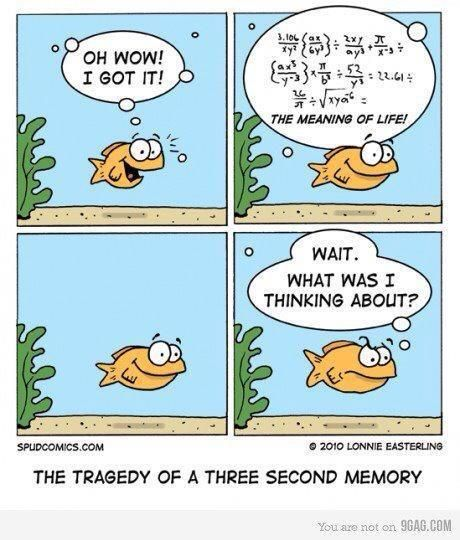

### A recurrent neural network (RNN) is an extension of a conventional feedforward neural network, which is able to handle a variable-length sequence input. The RNN handles the variable-length sequence by having a recurrent hidden state whose activation at each time is dependent on that of the previous time.

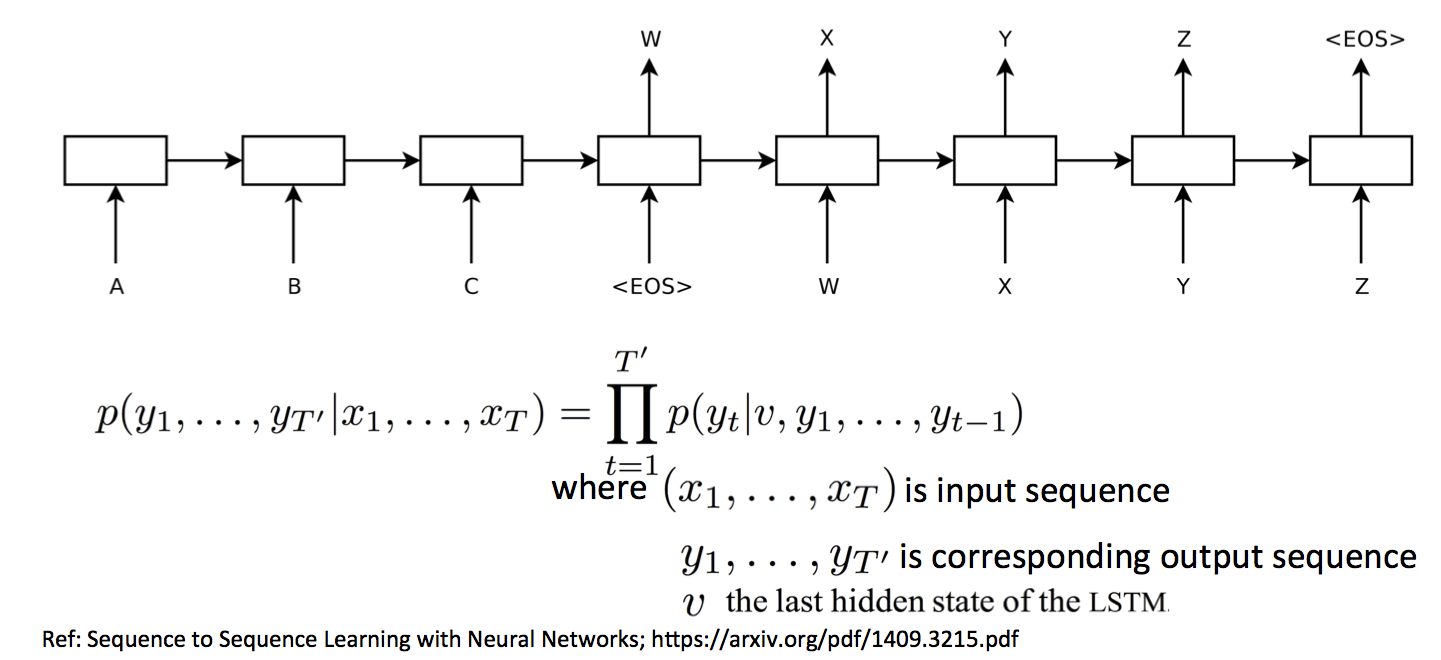

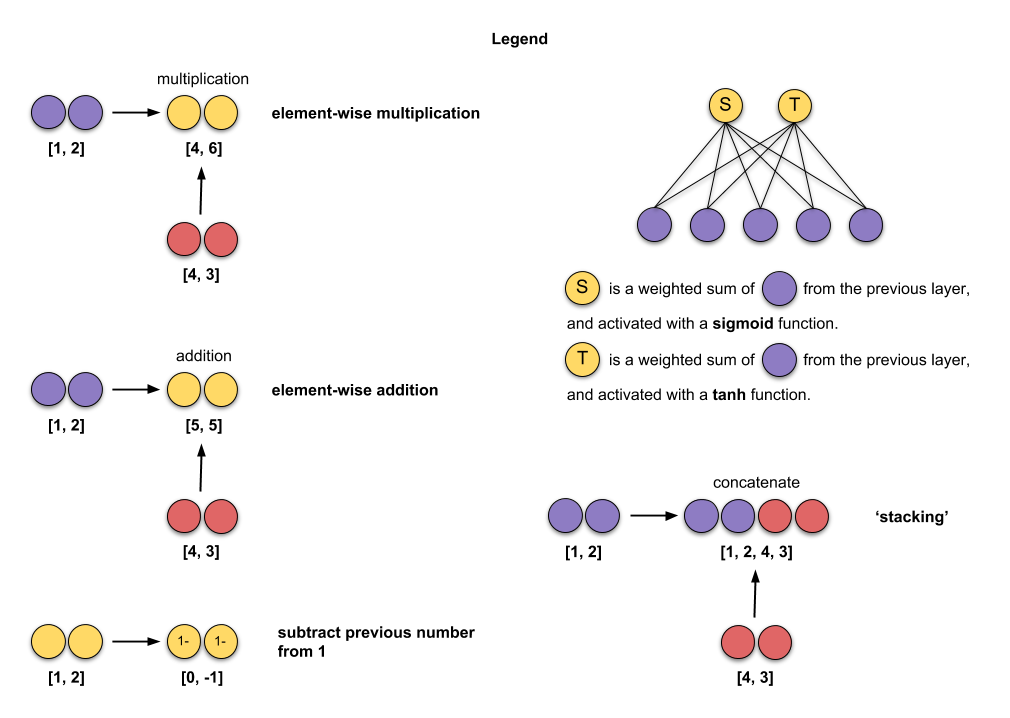

## Vanilla RNN

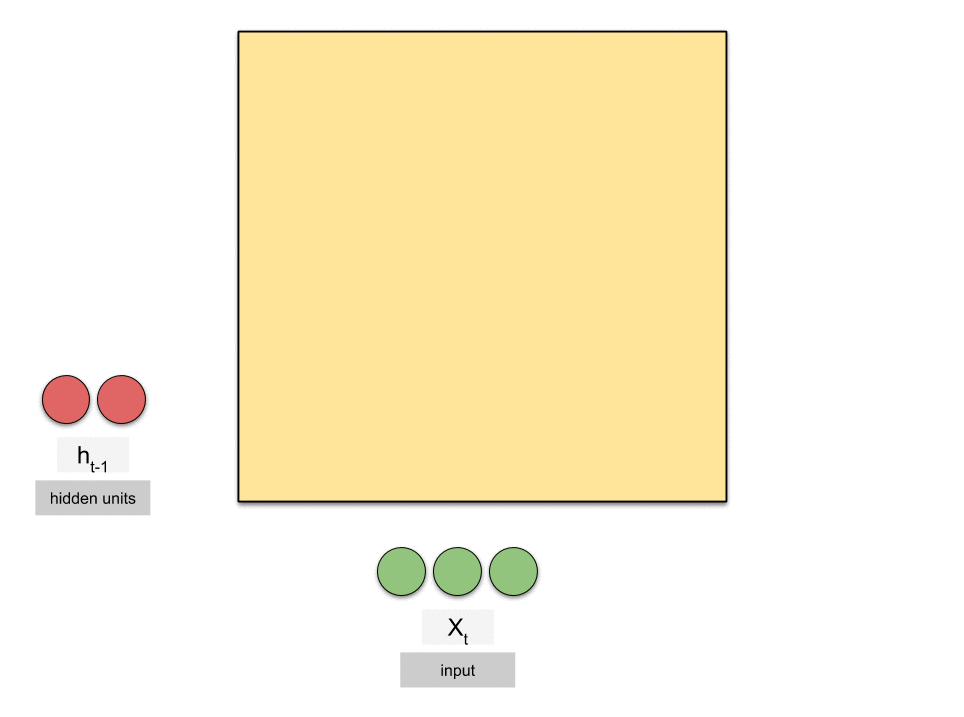

- t — time step
- X — input
- h — hidden state
- length of X — size/dimension of input
- length of h — no. of hidden units. Note that different libraries call them differently, but they mean the same:
- Keras — state_size ,units
- PyTorch — hidden_size
- TensorFlow — num_units

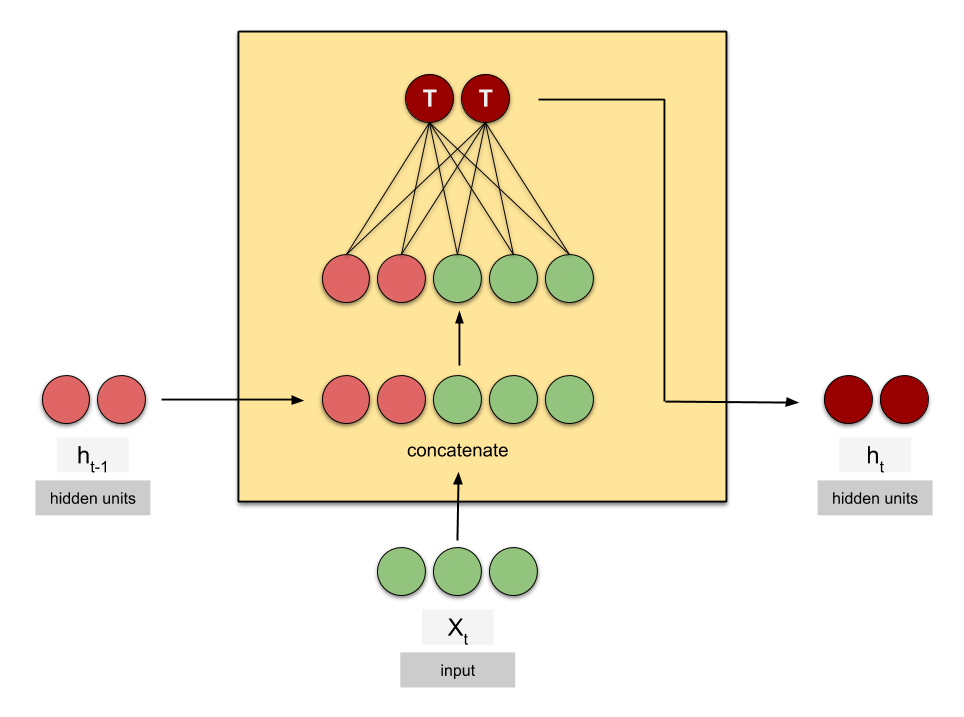

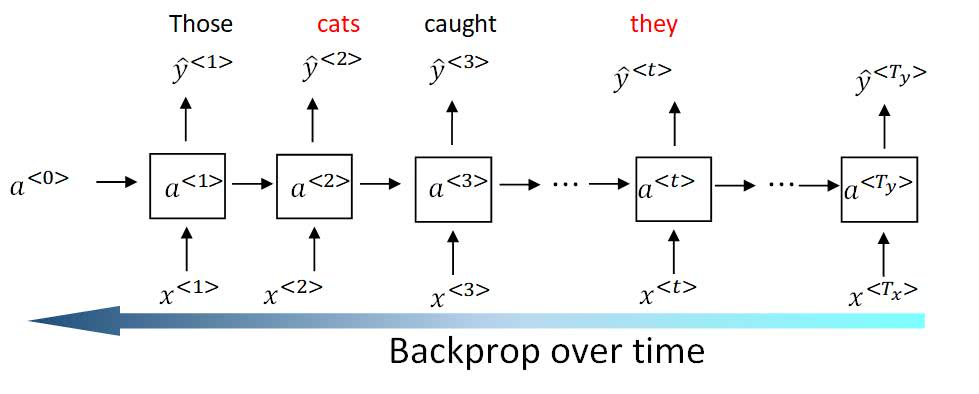

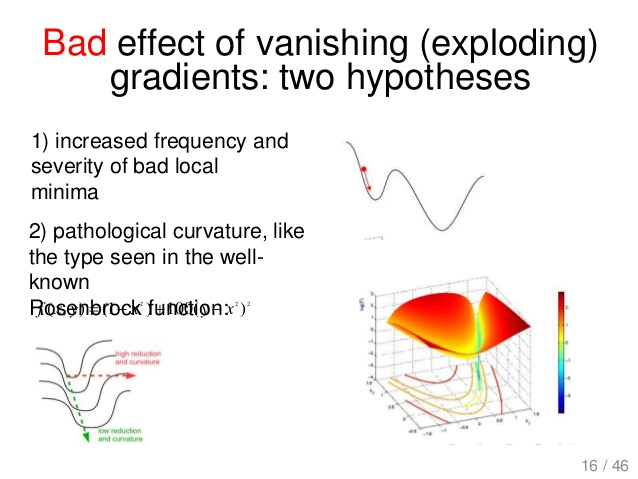

## GRU

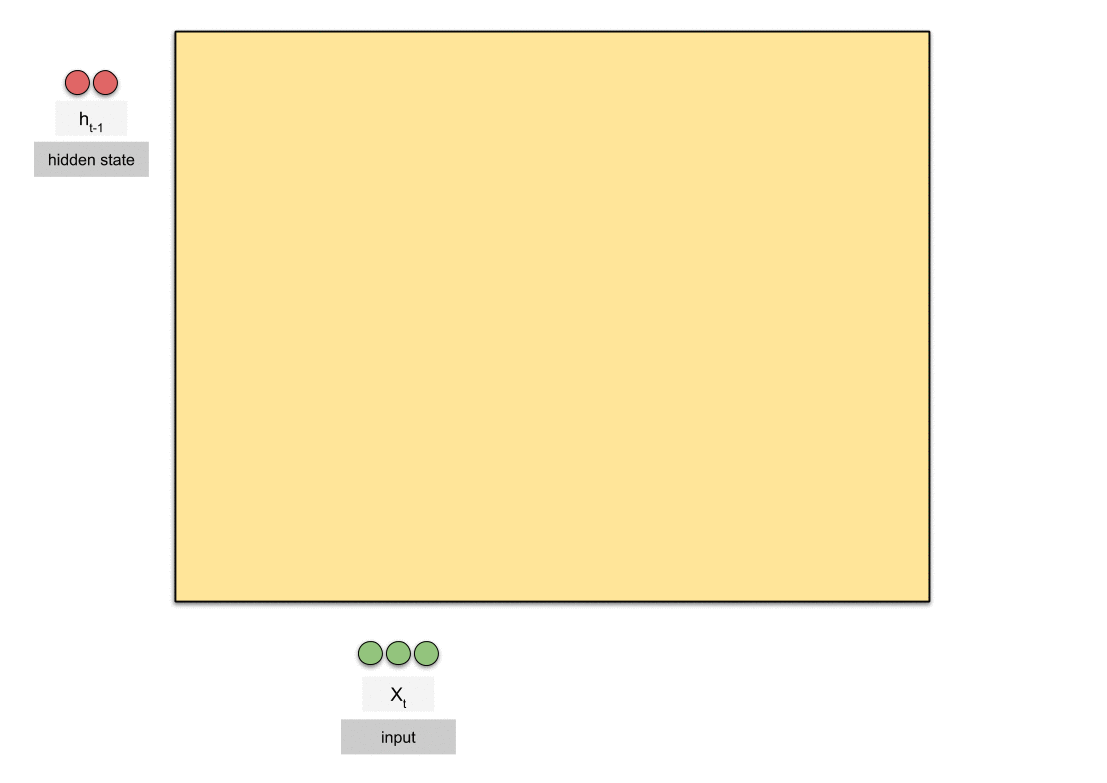

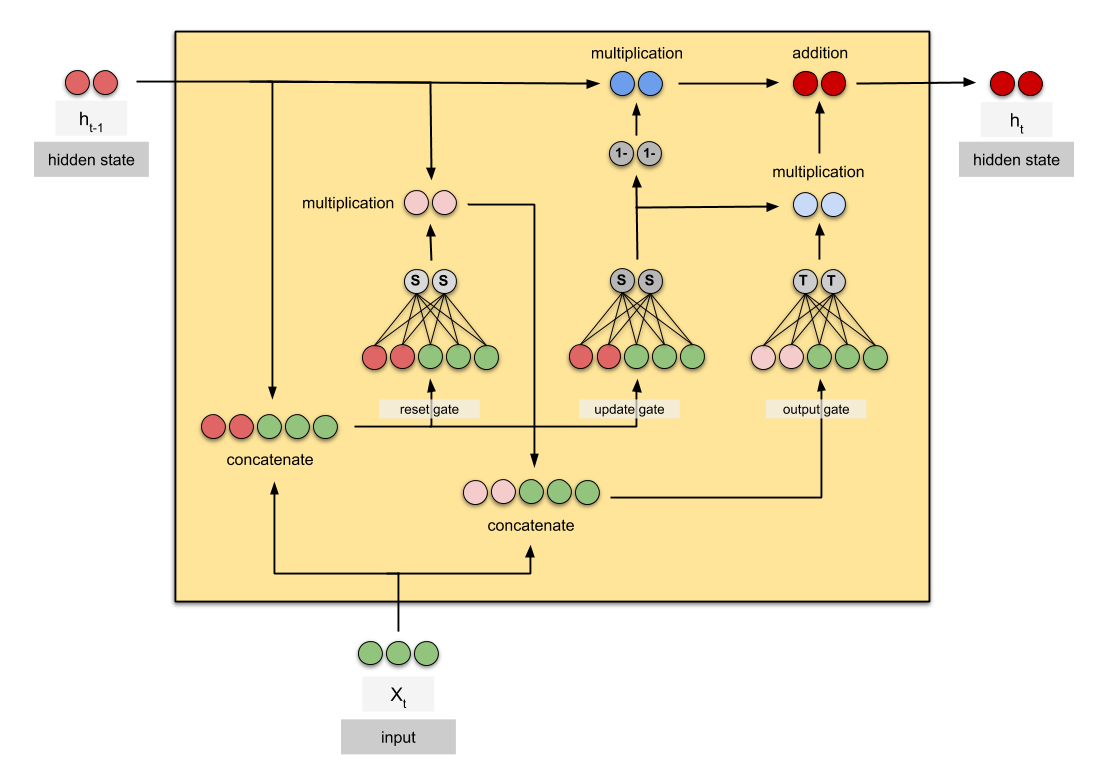

### A gated recurrent unit (GRU) was proposed by Cho et al. [2014] to make each recurrent unit to adaptively capture dependencies of different time scales. Similarly to the LSTM unit, the GRU has gating units that modulate the flow of information inside the unit, however, without having a separate memory cells.


## LSTM

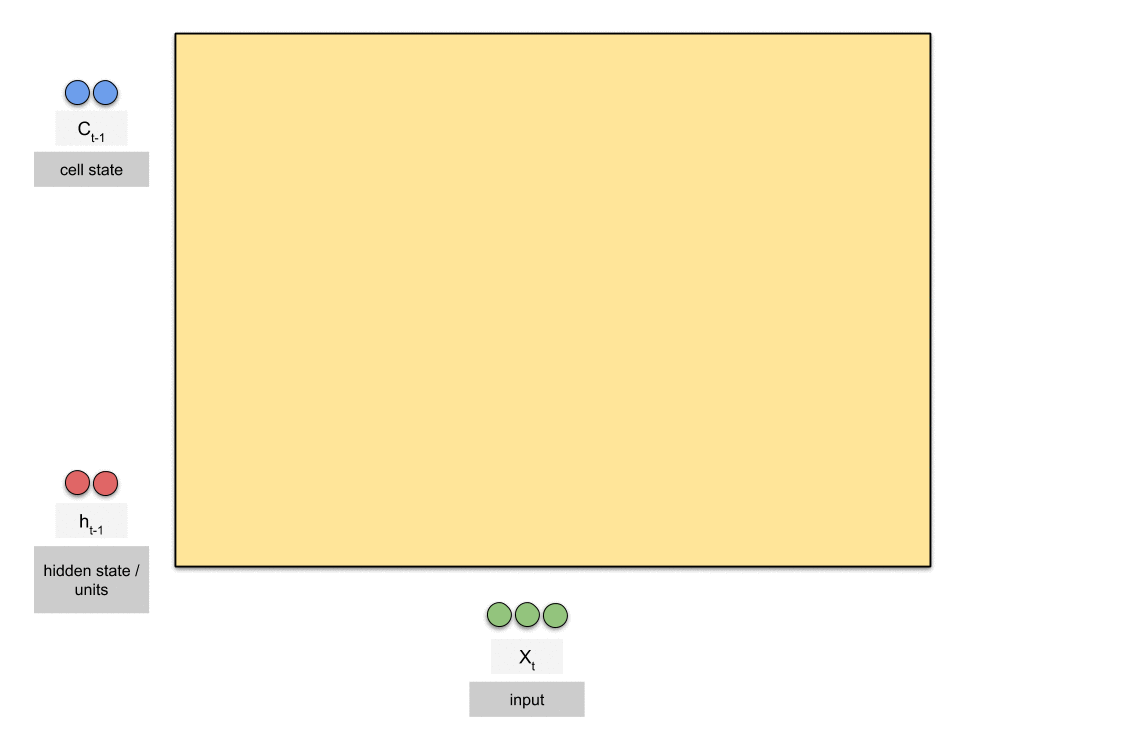

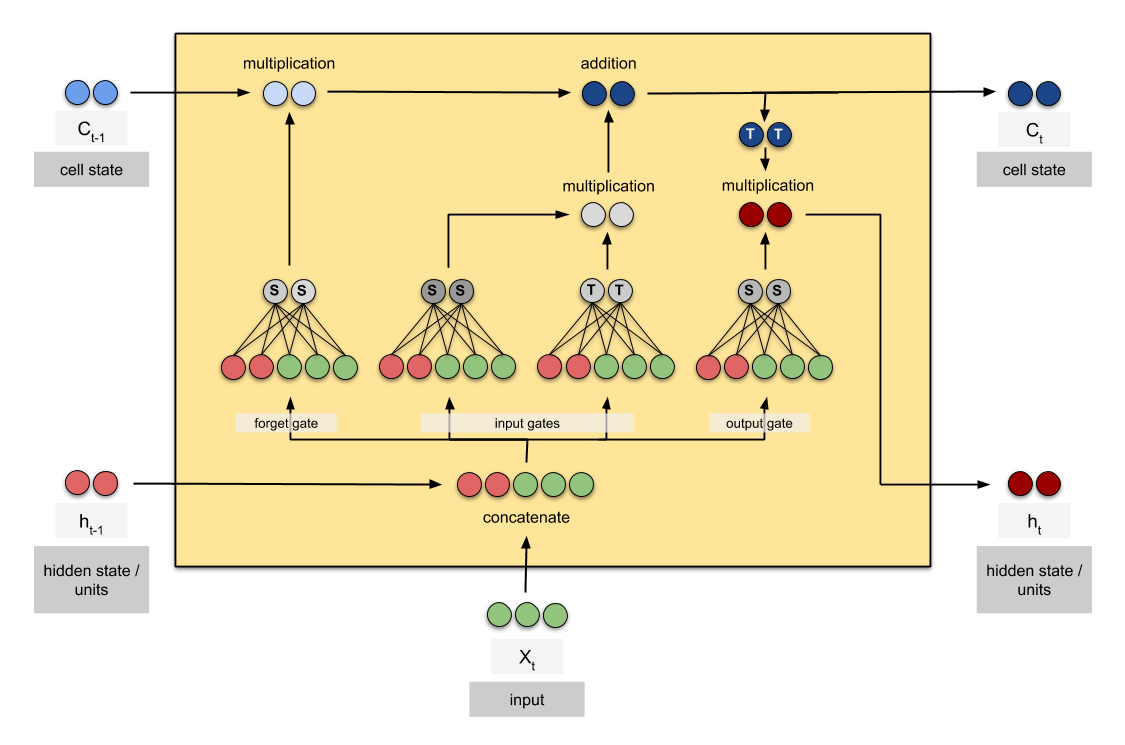

* output gate modulates the amount of memory content exposure
* The extent to which the existing memory is forgotten is modulated by a forget gate f j_t, and the degree to which the new memory content is added to the memory cell is modulated by an input gate
i_j t.
* Unlike to the traditional recurrent unit which overwrites its content at each time-step, an LSTM unit is able to decide whether to keep the existing memory via the introduced gates. Intuitively, if the LSTM unit detects an important feature from an input sequence at early stage, it easily carries this information (the existence of the feature) over a long distance, hence, capturing potential long-distance dependencies.

## Literature
* https://towardsdatascience.com/animated-rnn-lstm-and-gru-ef124d06cf45

## LSTM APPLICATION

In [20]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [21]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3

# input_size – The number of expected features in the input x
# hidden_size – The number of features in the hidden state h
# num_layers – Number of recurrent layers. E.g., setting num_layers=2 
#              would mean stacking two LSTMs together to form a stacked LSTM, 
#              with the second LSTM taking in outputs of the first LSTM and 
#              computing the final results. Default: 1
# bias – If False, then the layer does not use bias weights b_ih and b_hh. 
#              Default: True
# batch_first – If True, then the input and output tensors are provided as 
#               (batch, seq, feature). Default: False
# dropout – If non-zero, introduces a Dropout layer on the outputs of each 
#               LSTM layer except the last layer, with dropout probability 
#               equal to dropout. Default: 0
# bidirectional – If True, becomes a bidirectional LSTM. Default: False

inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

print(inputs)
print()
print(hidden)
print()
print(out)

[tensor([[-0.5525,  0.6355, -0.3968]]), tensor([[-0.6571, -1.6428,  0.9803]]), tensor([[-0.0421, -0.8206,  0.3133]]), tensor([[-1.1352,  0.3773, -0.2824]]), tensor([[-2.5667, -1.4303,  0.5009]])]

(tensor([[[-0.3600,  0.0893,  0.0215]]], grad_fn=<StackBackward>), tensor([[[-1.1298,  0.4467,  0.0254]]], grad_fn=<StackBackward>))

tensor([[[-0.3600,  0.0893,  0.0215]]], grad_fn=<StackBackward>)


In [22]:
# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
print(inputs)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[-0.5525,  0.6355, -0.3968]],

        [[-0.6571, -1.6428,  0.9803]],

        [[-0.0421, -0.8206,  0.3133]],

        [[-1.1352,  0.3773, -0.2824]],

        [[-2.5667, -1.4303,  0.5009]]])
tensor([[[-0.0187,  0.1713, -0.2944]],

        [[-0.3521,  0.1026, -0.2971]],

        [[-0.3191,  0.0781, -0.1957]],

        [[-0.1634,  0.0941, -0.1637]],

        [[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward>)
(tensor([[[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward>), tensor([[[-0.9825,  0.4715, -0.0633]]], grad_fn=<StackBackward>))


## Example: An LSTM for Part-of-Speech Tagging

The model is as follows: let our input sentence be w1,…,wM, where wi∈V, our vocab. Also, let T be our tag set, and yi the tag of word wi. Denote our prediction of the tag of word wi by y^i.

This is a structure prediction, model, where our output is a sequence y^1,…,y^M, where y^i∈T.

To do the prediction, pass an LSTM over the sentence. Denote the hidden state at timestep i as hi. Also, assign each tag a unique index (like how we had word_to_ix in the word embeddings section). Then our prediction rule for y^i is

y^i=argmaxj (logSoftmax(Ahi+b))j
That is, take the log softmax of the affine map of the hidden state, and the predicted tag is the tag that has the maximum value in this vector. Note this implies immediately that the dimensionality of the target space of A is |T|.

In [23]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(word_to_ix)
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


In [24]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [25]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    print("tag_scores",tag_scores)

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(tag_scores)

tag_scores tensor([[-1.1389, -1.2024, -0.9693],
        [-1.1065, -1.2200, -0.9834],
        [-1.1286, -1.2093, -0.9726],
        [-1.1190, -1.1960, -0.9916],
        [-1.0137, -1.2642, -1.0366]])
tensor([[-0.0462, -4.0106, -3.6096],
        [-4.8205, -0.0286, -3.9045],
        [-3.7876, -4.1355, -0.0394],
        [-0.0185, -4.7874, -4.6013],
        [-5.7881, -0.0186, -4.1778]])


Exercise: Augmenting the LSTM part-of-speech tagger with character-level features
In the example above, each word had an embedding, which served as the inputs to our sequence model. Let’s augment the word embeddings with a representation derived from the characters of the word. We expect that this should help significantly, since character-level information like affixes have a large bearing on part-of-speech. For example, words with the affix -ly are almost always tagged as adverbs in English.

To do this, let cw be the character-level representation of word w. Let xw be the word embedding as before. Then the input to our sequence model is the concatenation of xw and cw. So if xw has dimension 5, and cw dimension 3, then our LSTM should accept an input of dimension 8.

To get the character level representation, do an LSTM over the characters of a word, and let cw be the final hidden state of this LSTM. Hints:

There are going to be two LSTM’s in your new model. The original one that outputs POS tag scores, and the new one that outputs a character-level representation of each word.
To do a sequence model over characters, you will have to embed characters. The character embeddings will be the input to the character LSTM.

______________________________________________________________________________________________________________________________


In [44]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return Variable(tensor)

training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
            
print('word_to_ix')
print(word_to_ix)

char_to_ix = {}
char_to_ix[' '] = len(char_to_ix)
for sent, _ in training_data:
    for word in sent:
        for char in word:
            if char not in char_to_ix:
                char_to_ix[char] = len(char_to_ix)
                
print('char_to_ix')
print(char_to_ix)

tag_to_ix = {"DET": 0, "NN": 1, "V": 2}


class LSTMTaggerChar(nn.Module):
    def __init__(self, word_emb_dim, char_emb_dim, hidden_dim, vocab_size, tagset_size, char_size):
        super(LSTMTagger,self).__init__()
        self.hidden_dim = hidden_dim
        self.char_emb_dim = char_emb_dim


        self.word_embedding = nn.Embedding(vocab_size, word_emb_dim)
        self.char_embedding = nn.Embedding(char_size, char_emb_dim)
        self.char_lstm = nn.LSTM(char_emb_dim, char_emb_dim)
        self.lstm = nn.LSTM(word_emb_dim + char_emb_dim, hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence_word, sentence_char, MAX_WORD_LEN):

        sentence_size = sentence_word.size()[0]
        char_emb = self.char_embedding(sentence_char) 

        char_emb = char_emb.view(len(sentence_word), MAX_WORD_LEN, -1).permute(1,0,2) 

        self.hidden_char = self.initHidden_char(sentence_size)
        char_lstm_out, self.hidden = self.char_lstm(char_emb, self.hidden_char)
        char_embeded = char_lstm_out[-1,:,:].view(sentence_size,-1)


        word_embeded = self.word_embedding(sentence_word)

        embeded = torch.cat((word_embeded, char_embeded),dim=1)

        tag_space = self.hidden2tag(lstm_out.view(sentence_size,-1))
        tag_scores = F.log_softmax(tag_space)
        return tag_scores


CHAR_EMB_DIM = 3
MAX_WORD_LEN = 8

model = LSTMTagger(EMBEDDING_DIM, CHAR_EMB_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix), len(char_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

word_to_ix
{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}
char_to_ix
{' ': 0, 'T': 1, 'h': 2, 'e': 3, 'd': 4, 'o': 5, 'g': 6, 'a': 7, 't': 8, 'p': 9, 'l': 10, 'E': 11, 'v': 12, 'r': 13, 'y': 14, 'b': 15, 'k': 16}


In [47]:
print('Scores before training')

sentence_word = prepare_sequence(training_data[0][0], word_to_ix)
sent_chars = []
for w in training_data[0][0]:
    sps = ' ' * (MAX_WORD_LEN - len(w))
    sent_chars.extend(list(sps + w) if len(w) < MAX_WORD_LEN else list(w[:MAX_WORD_LEN]))
sentence_char = prepare_sequence(sent_chars, char_to_ix)

with torch.no_grad():
    tag_scores = model(sentence_word, sentence_char, MAX_WORD_LEN)
    targets = prepare_sequence(training_data[0][1], tag_to_ix)
    print('tag_scores: ',tag_scores)
    print('targets: ',targets)

for epoch in range(300):
    for sentence, tags in training_data:
        model.zero_grad()
        model.hidden = model.initHidden()
        sentence_word = prepare_sequence(sentence, word_to_ix)
        sent_chars = []
        for w in sentence:
            sps = ' ' * (MAX_WORD_LEN - len(w))
            sent_chars.extend(list(sps + w) if len(w)<MAX_WORD_LEN else list(w[:MAX_WORD_LEN]))
        sentence_char = prepare_sequence(sent_chars, char_to_ix)

        targets = prepare_sequence(tags, tag_to_ix)
        tag_scores = model(sentence_word, sentence_char, MAX_WORD_LEN)
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()


print('Scores after training')
with torch.no_grad():
    sentence_word = prepare_sequence(training_data[0][0], word_to_ix)
    sent_chars = []
    for w in training_data[0][0]:
        sps = ' ' * (MAX_WORD_LEN - len(w))
        sent_chars.extend(list(sps + w) if len(w) < MAX_WORD_LEN else list(w[:MAX_WORD_LEN]))
    sentence_char = prepare_sequence(sent_chars, char_to_ix)

    tag_scores = model(sentence_word, sentence_char, MAX_WORD_LEN)
    targets = prepare_sequence(training_data[0][1], tag_to_ix)
    print('tag_scores: ',tag_scores)
    print('targets: ',targets)

Scores before training
tag_scores:  tensor([[-0.2719, -1.4736, -4.7133],
        [-2.3936, -0.1036, -4.9463],
        [-3.6344, -3.5514, -0.0567],
        [-0.0490, -3.5700, -3.9297],
        [-2.8118, -0.0920, -3.5834]])
targets:  tensor([0, 1, 2, 0, 1])


C:\Users\Mi Notebook\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Scores after training
tag_scores:  tensor([[-0.0541, -3.0081, -5.7319],
        [-4.8130, -0.0106, -6.0238],
        [-4.5832, -5.0553, -0.0167],
        [-0.0107, -5.3828, -5.1081],
        [-4.3539, -0.0225, -4.6688]])
targets:  tensor([0, 1, 2, 0, 1])
